In [1]:
import nltk
nltk.download("stopwords") #nltk 패키지에서 불용어 사전을 다운로드 받고, 데이터 전처리를 위한 나머지 패키지도 함께 불러온다.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\82102\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

In [4]:
file_path = os.path.dirname(os.path.abspath('__file__')) + r'/Reviews.csv'
data = pd.read_csv(file_path, nrows=100000)
print("전체 샘플 수 :", len(data))

전체 샘플 수 : 100000


In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data = data[['Text', 'Summary']] #사용할 text열과 summary열만 출력한다.
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [7]:
# 랜덤한 3개 샘플 출력
data.sample(15)

,Text,Summary
20948,"I love these chips! They're all natural, glut...",Love These!
8370,"I didn't know what this would taste like, but ...",Amazing!
99154,"This licorice has quite a strong anise flavor,...",Very Strongly Flavored
58676,"This *NOW* brand of xylitol tastes sweet, not ...",Tastes *sweet* not bitter. Double Hi-5! ~~~ fo...
87434,Purchased these noodles when our family was pu...,Such a waste of money
19943,Tried different brand from local candy store. ...,Best I've Found
34338,"Great to keep my Bostons teeth clean, Watch ou...",Nice Teeth!
26734,Purchased the roasted chicken flavor and produ...,Dog wasn't a fan
85577,My family will eat it. I have Celiac and am al...,"Love it, price it right"
4385,My parents fell in love with 'San Francisco Ba...,Not San Francisco Bay Coffee Company


In [8]:
print("Text 열에서 중복을 배제한 유일한 샘플의 수 :", data['Text'].nunique())
print("Summary 열에서 중복을 배제한 유일한 샘플의 수 :", data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [9]:
data.drop_duplicates(subset=['Text'], inplace=True) #drop_duplicates()를 사용하여 중복 샘플을 제거
print("전체 샘플 수 :", len(data))

전체 샘플 수 : 88426


In [10]:
data.isnull().sum() #데이터 프레임에 Null값이 있는지 확인

Text       0
Summary    1
dtype: int64

In [11]:
data.dropna(axis=0, inplace=True) #데이터프레임에서 Null값을 제거
print("전체 샘플 수:", len(data))

전체 샘플 수: 88425


In [12]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [13]:
print("불용어의 개수 : ", len(stopwords.words('english')))
print(stopwords.words('english'))

불용어의 개수 :  179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 

In [14]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, 'lxml').text # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    
    return tokens

In [15]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [16]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 꽤 오래 걸릴 수 있습니다.
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

In [17]:
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [18]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 -> 5분 이상의 시간이 걸릴 수 있습니다.
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [19]:
clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [20]:
#데이터들을 데이터프레임에 재저장
data['Text'] = clean_text
data['Summary'] = clean_summary 

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [21]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [22]:
data.dropna(axis=0, inplace=True)
print('전체 샘플 수 :', len(data))

전체 샘플 수 : 88355


In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print("텍스트의 최소 길이 : ", np.min(text_len))
print("텍스트의 최대 길이 : ", np.max(text_len))
print("텍스트의 평균 길이 : ", np.mean(text_len))
print("요약의 최소 길이 : ", np.min(summary_len))
print("요약의 최대 길이 : ", np.max(summary_len))
print("요약의 평균 길이 : ", np.mean(summary_len))

텍스트의 최소 길이 :  2
텍스트의 최대 길이 :  1235
텍스트의 평균 길이 :  38.792428272310566
요약의 최소 길이 :  1
요약의 최대 길이 :  28
요약의 평균 길이 :  4.010729443721352


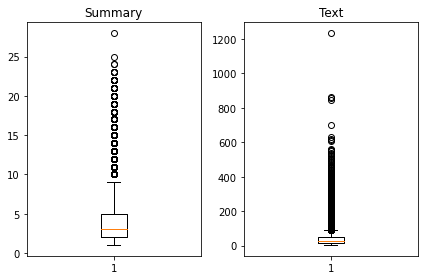

In [24]:
plt.subplot(1, 2, 1)
plt.boxplot(summary_len)
plt.title("Summary")

plt.subplot(1, 2, 2)
plt.boxplot(text_len)
plt.title("Text")
plt.tight_layout()

plt.show()

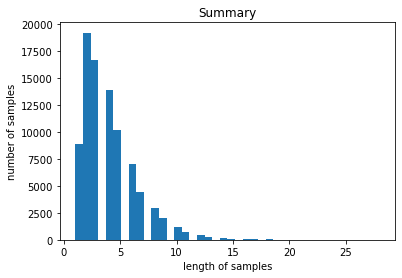

In [25]:
plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

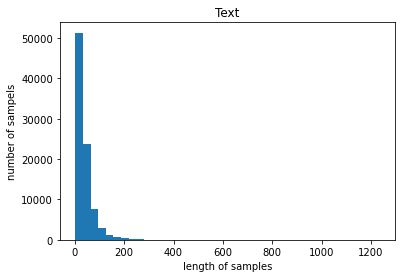

In [26]:
plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of sampels')
plt.show()

In [27]:
#text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정하기
text_max_len = 50
summary_max_len = 8

In [28]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if len(s.split()) <= max_len:
            cnt = cnt + 1
    print("전체 샘플 중 길이가 {} 이하인 샘플의 비율 : {}".format(max_len, (cnt/len(nested_list))))

In [31]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율 : 1.0
전체 샘플 중 길이가 8 이하인 샘플의 비율 : 1.0


In [32]:
data = data[data['Text'].apply(lambda x : len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x : len(x.split()) <= summary_max_len)]
print("전체 샘플 수 : ", len(data))

전체 샘플 수 :  65818


In [33]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken ' + x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [34]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [35]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[23918 63117 61088 ... 52542 63347 40802]


In [36]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [37]:
n_of_val = int(len(encoder_input) * 0.2) #전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의
print("테스트 데이터의 수 :", n_of_val)

테스트 데이터의 수 : 13163


In [38]:
#전체 데이터 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print("훈련 데이터의 갯수 :", len(encoder_input_train))
print("훈련 레이블의 갯수 :", len(decoder_input_train))
print("테스트 데이터의 갯수 :", len(encoder_input_test))
print("테스트 데이터의 갯수 :", len(decoder_input_test))

훈련 데이터의 갯수 : 52655
훈련 레이블의 갯수 : 52655
테스트 데이터의 갯수 : 13163
테스트 데이터의 갯수 : 13163


In [39]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [40]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold 보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도 수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
    

print("단어 집합(vocabulary)의 크기 : ", total_cnt)
print("등장 빈도가 {}번 이하인 희귀 단어의 수 : {}".format(threshold-1, rare_cnt))
print("단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 : ", total_cnt - rare_cnt)
print("단어 집합에서 희귀 단어의 비율 : ", (rare_cnt/total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도의 비율 : ", (rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기 :  32092
등장 빈도가 6번 이하인 희귀 단어의 수 : 23843
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 :  8249
단어 집합에서 희귀 단어의 비율 :  74.29577464788733
전체 등장 빈도에서 희귀 단어 등장 빈도의 비율 :  3.3995276376127808


In [41]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [42]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[989, 435, 13, 311, 35, 83, 170, 140, 6771, 272, 104, 318, 83, 777, 57, 830, 996, 17, 1, 149, 3233, 256, 54, 244, 229, 14, 487, 1, 373, 91, 54, 57, 1478, 1, 313, 655, 830, 12, 119, 719, 1403], [6, 1729, 382, 17, 20, 17, 694, 138, 13], [65, 2822, 53, 901, 119, 242, 302, 53, 330, 397, 674, 1105, 546, 1541, 84, 1251, 7, 3, 2351, 18]]


In [43]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train) # 전체 단어 집합과 각 단어에 대한 빈도수를 계산

In [44]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10527
등장 빈도가 5번 이하인 희귀 단어의 수: 8124
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2403
단어 집합에서 희귀 단어의 비율: 77.17298375605586
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.862024444826992


In [45]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)

decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환 되었는지 확인
print("input!")
print("input : ", decoder_input_train[:5])
print("output!")
print("ouput : ", decoder_target_train[:5])

input!
input :  [[1, 24], [1, 3, 16, 69, 30], [1, 21, 4], [1, 1954], [1, 3, 16, 170, 165]]
output!
ouput :  [[24, 2], [3, 16, 69, 30, 2], [21, 4, 2], [1954, 2], [3, 16, 170, 165, 2]]


In [46]:
#훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test라는 변수에 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print("삭제할 훈련 데이터의 갯수 : ", len(drop_train))
print("삭제할 테스트 데이터의 갯수 : ", len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print("---")
print("훈련 데이터의 갯수 : ", len(encoder_input_train))
print("훈련 레이블의 갯수 : ", len(decoder_input_train))
print("테스트 데이터의 갯수 : ", len(encoder_input_test))
print("테스트 레이블의 갯수 : ", len(decoder_input_test))

삭제할 훈련 데이터의 갯수 :  1277
삭제할 테스트 데이터의 갯수 :  326
---
훈련 데이터의 갯수 :  51378
훈련 레이블의 갯수 :  51378
테스트 데이터의 갯수 :  12837
테스트 레이블의 갯수 :  12837


In [47]:
# 최대 길이로 패딩, 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이 맞추기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')

decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

# 모델설계

In [48]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape = (text_max_len, ))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [49]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 lstm
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout=0.4, recurrent_dropout = 0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [50]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [51]:
#깃허브에 공개된 어텐션 함수 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [52]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name = 'attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하과 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

# 모델 훈련

In [53]:
model.compile(optimizer = 'rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(
    x = [encoder_input_train, decoder_input_train],
    y = decoder_target_train,
    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size = 256,
    callbacks = [es],
    epochs = 12
)
# val_loss(검증 데이터의 손실)을 모니터링, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 (parience = 2) 2회 관측되면 학습을 멈추도록 설정

Epoch 1/12
201/201 [==============================] - 2957s 15s/step - loss: 2.7048 - val_loss: 2.4286
Epoch 2/12
201/201 [==============================] - 3285s 16s/step - loss: 2.3941 - val_loss: 2.2944
Epoch 3/12
201/201 [==============================] - 3387s 17s/step - loss: 2.2436 - val_loss: 2.1556
Epoch 4/12
201/201 [==============================] - 3375s 17s/step - loss: 2.1200 - val_loss: 2.0629
Epoch 5/12
201/201 [==============================] - 3242s 16s/step - loss: 2.0341 - val_loss: 2.0110
Epoch 6/12
201/201 [==============================] - 3449s 17s/step - loss: 1.9686 - val_loss: 1.9694
Epoch 7/12
201/201 [==============================] - 3523s 18s/step - loss: 1.9156 - val_loss: 1.9420
Epoch 8/12
201/201 [==============================] - 3595s 18s/step - loss: 1.8699 - val_loss: 1.9108
Epoch 9/12
201/201 [==============================] - 3609s 18s/step - loss: 1.8283 - val_loss: 1.8944
Epoch 10/12
201/201 [==============================] - 3615s 18s/step - l

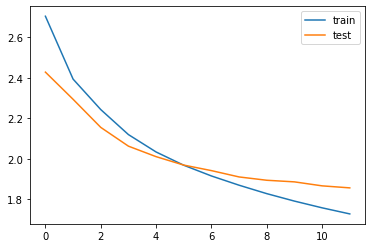

In [54]:
#훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현하기

In [55]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [56]:
# 인코더 설계
encoder_model = Model(inputs = encoder_inputs, outputs = [encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape = (hidden_size, ))
decoder_state_input_c = Input(shape = (hidden_size, ))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(Initial state)를 이전 시점의 상태로 사용. 
# 이는 뒤의 함수 decode_sequence()에서 구현합니다.
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셸 상태인 state_h와 state_c를 버리지 않습니다.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [57]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape = (text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

In [58]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']
    
    stop_condition = False
    decoded_sentence = ""
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token
        
        # <EOS>에 도달하거나 최대 길이를 넘으면 중단
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= summary_max_len - 1:
            stop_condition = True
        
        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros([1, 1])
        target_seq[0, 0] = sampled_token_index
        
        # 상태 업데이트
        e_h, e_c = h, c
    
    return decoded_sentence

# 모델테스트

In [59]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp = ''
    for i in input_seq:
        if i != 0:
            temp = temp + src_index_to_word[i] + ' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ""
    for i in input_seq:
        if i != 0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [60]:
#테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 100):
    print("원문 : ", seq2text(encoder_input_test[i]))
    print("실제 요약 : ", seq2summary(decoder_input_test[i]))
    print("예측 요약 : ", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  love concept pure juice carbonation taste pretty good good enough become regular purchase definitely good enough try maybe pick curious try flavors 
실제 요약 :  pretty good stuff 
예측 요약 :   not bad


원문 :  favorite spices cannot beat price would pay tiny tin pumpkin pie spice grocery would definitely recommend 
실제 요약 :  love these spices 
예측 요약 :   great product


원문 :  drink mostly german brazilian coffees smooth strong flavor received coffee gift found pleasing favorites bitter acidic taste strong enough please palate organic free trade coffee one delicious 
실제 요약 :  no bitter acidic taste 
예측 요약 :   not my favorite


원문 :  one favorite flavors peppers seasoning packet pretty spicy price decent easy meal option buy cent store honestly amount getting would pay dollar things tasty bit different usual cup noodle 
실제 요약 :  spicy good 
예측 요약 :   good stuff


원문 :  purchased nut company pears gift brother twice extremely tasty fresh come three pack stay fresh long time definitely order 